In [11]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import os, sys
sys.path.append(os.path.abspath("C:/Users/JORDAN LONTSI/Desktop/Research project/Python script/Final_script/"))
from util_func import *
from subprocess import check_output
#print(check_output(["dir", "."]).decode("utf8"))

import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* Load all galaxy types from **all** directory

In [12]:
pt = 'C:/Users/JORDAN LONTSI/Desktop/Research project/Python script/Final_script/galaxy_data/all/'

compact_dir = os.path.join(pt,'Compact')
fri_dir = os.path.join(pt,'FRI')
frii_dir = os.path.join(pt,'FRII')
bent_dir = os.path.join(pt, 'Bent')

compact_images = load_random_images(compact_dir)
fri_images = load_random_images(fri_dir)
frii_images = load_random_images(frii_dir)
bent_images = load_random_images(bent_dir)

* Visualise selected galaxy types

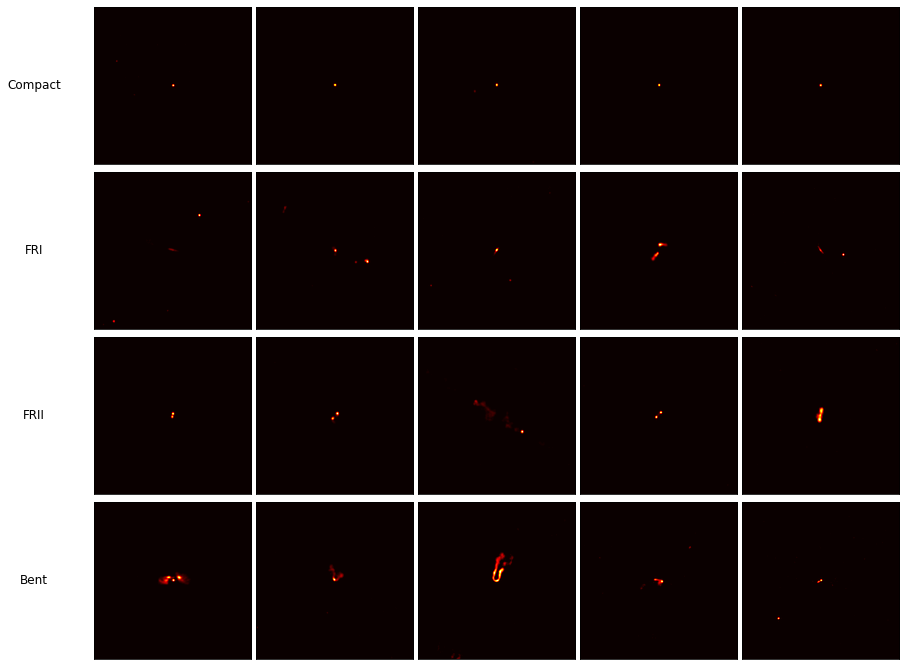

In [13]:
# Create 4x5 subplot
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Adjust spacing to make room for y-axis labels
plt.subplots_adjust(wspace=0, hspace=0.05, left=0.15)

# Add images to subplots and remove ticks
for i, images in enumerate([compact_images, fri_images, frii_images, bent_images]):
    for j, img in enumerate(images):
        ax = axes[i, j]
        ax.imshow(img, cmap='hot', interpolation='lanczos')
        if j == 0:
            # Add y-axis labels to the first column
            row_labels = ['Compact', 'FRI', 'FRII', 'Bent']
            ax.set_ylabel(row_labels[i], rotation=0, size='large', labelpad=60, va='center')
        # Remove ticks and tick labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    # ax.axis('off')  # Remove ticks and labels

plt.show()

* Load and resize data

In [19]:
Nx = 64
Ny = 64
Nz= 300 # 348
bent_data = load_resize_normalize_images(directory=bent_dir, target_shape=(Nx, Ny), n=Nz)
compact_data = load_resize_normalize_images(directory=compact_dir, target_shape=(Nx, Ny), n=Nz)
fri_data = load_resize_normalize_images(directory=fri_dir, target_shape=(Nx, Ny), n=Nz)
frii_data = load_resize_normalize_images(directory=frii_dir, target_shape=(Nx, Ny), n=Nz)

* Decompose Galaxy images \& pickle the decomposed components 

In [20]:
U_bent, S_bent, Vt_bent = custom_svd(bent_data)
U_compact, S_compact, Vt_compact = custom_svd(compact_data)
U_fri, S_fri, Vt_fri = custom_svd(fri_data)
U_frii, S_frii, Vt_frii = custom_svd(frii_data)
print(U_fri.shape, S_fri.shape, Vt_fri.shape)

# pickling the various U, S, and V components
file_path = "arrays_data_64_sz150.pkl"
processor = ArrayProcessor(file_path)
arrays_dict = {
     "U_bent": U_bent,
    "S_bent": S_bent,
    "Vt_bent": Vt_bent,
     "U_compact": U_compact,
    "S_compact": S_compact,
    "Vt_compact": Vt_compact,
    "U_fri": U_fri,
    "S_fri": S_fri,
    "Vt_fri": Vt_fri,
     "U_frii": U_frii,
    "S_frii": S_frii,
    "Vt_frii": Vt_frii,
}
# Save arrays using the class method
processor.save_arrays(arrays_dict)

(3, 300, 300) (3, 300) (3, 300, 4096)
Arrays saved to arrays_data_64_sz150.pkl


* Load arrays using the class method (NB: U can always load array after decomposition)

In [21]:
file_path = "arrays_data_64_sz150.pkl"
processor = ArrayProcessor(file_path)
loaded_arrays = processor.load_arrays()
loaded_arrays.keys()

Arrays loaded from arrays_data_64_sz150.pkl


dict_keys(['U_bent', 'S_bent', 'Vt_bent', 'U_compact', 'S_compact', 'Vt_compact', 'U_fri', 'S_fri', 'Vt_fri', 'U_frii', 'S_frii', 'Vt_frii'])

In [22]:
U_bent = loaded_arrays["U_bent"]
S_bent = loaded_arrays["S_bent"] 
Vt_bent = loaded_arrays["Vt_bent"]
U_compact = loaded_arrays["U_compact"]
S_compact = loaded_arrays["S_compact"]
Vt_compact = loaded_arrays["Vt_compact"]
U_fri = loaded_arrays["U_fri"]
S_fri = loaded_arrays["S_fri"] 
Vt_fri = loaded_arrays["Vt_fri"] 
U_frii = loaded_arrays["U_frii"] 
S_frii = loaded_arrays["S_frii"] 
Vt_frii = loaded_arrays["Vt_frii"] 

* Singular value plot for Bent, FRI, FRII, and Compact

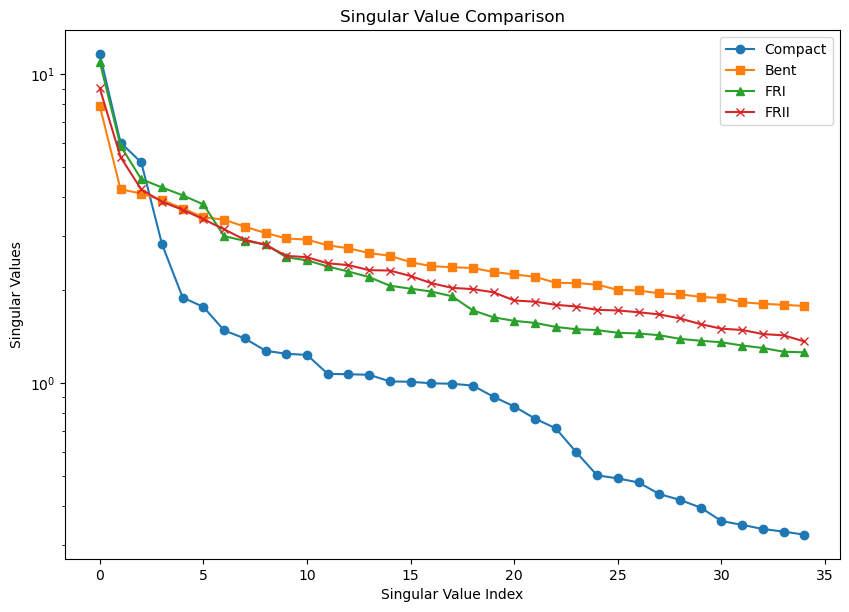

In [18]:
compact_Smax = np.max(S_compact, axis=0)
bent_Smax = np.max(S_bent, axis=0)
fri_Smax = np.max(S_fri, axis=0)
frii_Smax = np.max(S_frii, axis=0)
N = 35
# Create a figure
fig, ax = plt.subplots(figsize=(10, 7), dpi=100)

# Plot all singular value sets with legends
ax.semilogy(compact_Smax[:N], 'o-', label='Compact')
ax.semilogy(bent_Smax[:N], 's-', label='Bent')
ax.semilogy(fri_Smax[:N], '^-', label='FRI')
ax.semilogy(frii_Smax[:N], 'x-', label='FRII')

# Set labels and title
ax.set_xlabel('Singular Value Index')
ax.set_ylabel('Singular Values')
ax.set_title('Singular Value Comparison')
ax.legend()


In [23]:
bent_data.shape, fri_data.shape, frii_data.shape, compact_data.shape

((300, 64, 64, 3), (300, 64, 64, 3), (300, 64, 64, 3), (300, 64, 64, 3))

* Reconstruct decomposed Galaxy images using truncated SVD

In [24]:
threshold = 130

nchan_bent, sx, sy, r = bent_data.shape
nchan_compact = compact_data.shape[0]
nchan_fri = fri_data.shape[0]
nchan_frii = frii_data.shape[0]
recons_compact = np.zeros_like(compact_data)
recons_bent = np.zeros_like(bent_data)
recons_fri = np.zeros_like(fri_data)
recons_frii = np.zeros_like(frii_data)
coeff_compact = np.zeros(shape=(r,nchan_compact, nchan_compact))
coeff_bent = np.zeros(shape=(r,nchan_bent, nchan_bent))
coeff_fri = np.zeros(shape=(r,nchan_fri, nchan_fri))
coeff_frii = np.zeros(shape=(r,nchan_frii, nchan_frii))

for c in range(3):
    recons, coeff = svdreconstruct(Ur=U_bent[c], Sr=S_bent[c], Vr=Vt_bent[c, ...], topN=threshold)
    recons_bent[...,c], coeff_bent[c,...] = recons.reshape(nchan_bent,sx, sy), coeff 
    recons, coeff = svdreconstruct(Ur=U_compact[c], Sr=S_compact[c], Vr=Vt_compact[c, ...], topN=threshold)
    recons_compact[...,c], coeff_compact[c,...] = recons.reshape(nchan_compact,sx, sy), coeff 
    recons, coeff = svdreconstruct(Ur=U_fri[c], Sr=S_fri[c], Vr=Vt_fri[c, ...], topN=threshold)
    recons_fri[...,c], coeff_fri[c,...] = recons.reshape(nchan_fri,sx, sy), coeff 
    recons, coeff = svdreconstruct(Ur=U_frii[c], Sr=S_frii[c], Vr=Vt_frii[c, ...], topN=threshold)
    recons_frii[...,c], coeff_frii[c,...] = recons.reshape(nchan_frii,sx, sy), coeff 

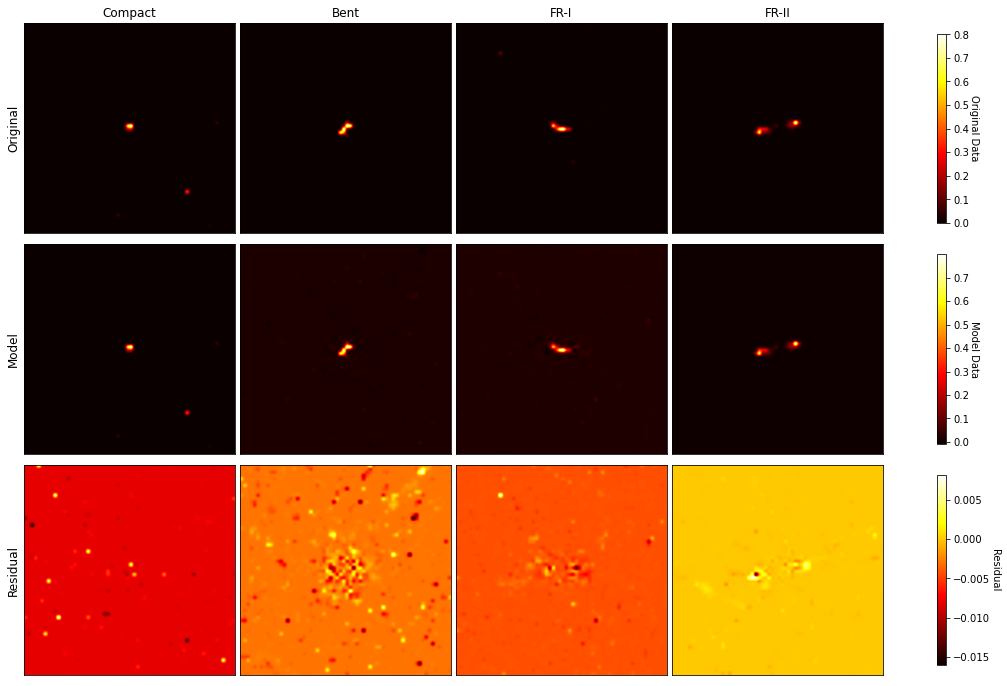

In [51]:
nchan = 45
orig = np.stack((compact_data[nchan], bent_data[nchan], fri_data[nchan], frii_data[nchan]))
recons = np.stack((recons_compact[nchan], recons_bent[nchan], recons_fri[nchan], recons_frii[nchan]))
res = np.stack((compact_data[nchan] - recons_compact[nchan],
                bent_data[nchan] - recons_bent[nchan],
                fri_data[nchan] - recons_fri[nchan],
                frii_data[nchan] - recons_frii[nchan]))

# plot_subplotsq(original_data=orig, model_data=recons, residuals=res)
orig =  resize_data(data = orig, new_size=(256, 256))
recons = resize_data(data = recons, new_size=(256, 256))
res = resize_data(data = res, new_size=(256, 256))

plot_subplotsq(original_data=orig[...,0], model_data=recons[...,0], residuals=res[...,0], set_title=['Compact', 'Bent', 'FR-I', 'FR-II'])

## ML parts

In [57]:
from sklearn.manifold import TSNE

* convert the galaxy arrays into a DataFrame and add the target column

In [79]:
ncols = 120
shp_fri = coeff_fri.shape[-1]
shp_frii = coeff_frii.shape[-1]
shp_compact = coeff_compact.shape[-1]
shp_bent = coeff_bent.shape[-1]


# Combine arrays into one large array
combined_data = np.vstack([np.max(coeff_fri, axis=0)[:, :ncols],
                           np.max(coeff_frii, axis=0)[:, :ncols],
                           np.max(coeff_compact, axis=0)[:, :ncols],
                           np.max(coeff_bent, axis=0)[:, :ncols]])

# Select the first 120 columns
# selected_data = combined_data[:, :ncols]


# Create a DataFrame
df = pd.DataFrame(combined_data, columns=[f'p{i}' for i in range(ncols)])

# Add target column
targets = np.array([0]*shp_fri + [1]*shp_frii + [2]*shp_compact+ [3]*shp_bent)
df['target'] = targets
df.head() 

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p111,p112,p113,p114,p115,p116,p117,p118,p119,target
0,-0.085826,0.065689,-0.089268,0.010699,-0.007109,0.041302,-0.020074,0.008572,-0.003114,0.018406,...,-0.009378,0.007837,-0.005471,0.005504,-0.001444,0.002122,-0.003901,0.000713,-0.002706,0
1,-0.910076,0.488168,0.279941,-0.461762,-0.078760,0.032309,-0.060478,0.206858,-0.084019,-0.045230,...,0.016311,0.019310,0.006709,-0.014507,-0.005254,-0.017199,0.005808,0.004148,0.010150,0
2,-0.350739,-0.398986,-0.010367,0.311922,-0.400756,-0.136639,-0.191602,-0.170940,0.023423,-0.347428,...,0.002446,-0.007429,0.002327,-0.017503,0.016884,0.007963,-0.012367,0.013219,0.020235,0
3,-1.190538,-1.231510,0.015747,0.469711,0.287632,-0.433137,-0.133911,0.625128,-0.264636,0.266037,...,-0.049501,-0.012836,0.054868,-0.158883,-0.004912,0.032694,0.085613,-0.038375,-0.076843,0
4,-0.066323,-0.043380,-0.005485,-0.006695,-0.014565,0.008195,0.002859,-0.018268,0.018847,-0.012718,...,-0.001437,0.027251,0.013308,-0.005483,0.010168,-0.018133,-0.000636,0.011704,-0.006039,0


* Visualise the extracted features in 2D-TSNE

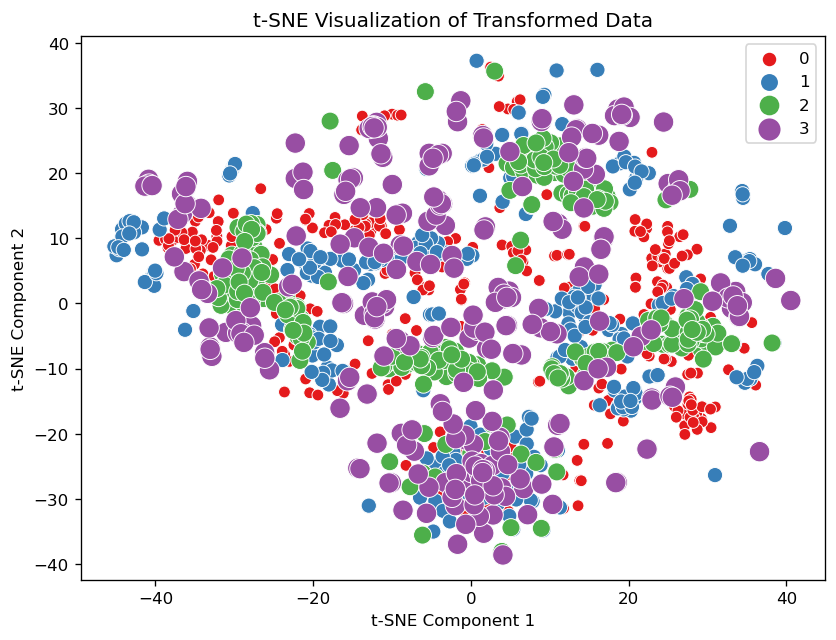

In [180]:
ncols = 2

# Transform X using U and S
transformed_X = combined_data.copy() #np.dot(U, np.diag(S))

# Apply t-SNE to transformed_X
tsne = TSNE(n_components=2, random_state=42)
transformed_tsne = tsne.fit_transform(transformed_X)
# Create a DataFrame
df_tsne = pd.DataFrame(transformed_tsne, columns=[f'tsne{i}' for i in range(ncols)])
df_tsne['target'] = targets.copy()

# Plotting the t-SNE transformed data
plt.figure(figsize=(8, 6), dpi=120)
# plt.scatter(transformed_tsne[:, 0], transformed_tsne[:, 1], color='blue', label='t-SNE Transformed Data')
sns.scatterplot(data=df_tsne, x='tsne0', y='tsne1', hue='target', size='target', sizes=(50, 150), palette='Set1', legend='full')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Transformed Data')
plt.legend()
plt.grid(False)
plt.show()

* Run ML models

In [182]:
df_balanced = df.copy()

In [183]:
model_comp = ModelComparison(df=df_balanced, target='target')
model_comp.train_models()
model_comp.train_ensemble_models()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 120
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

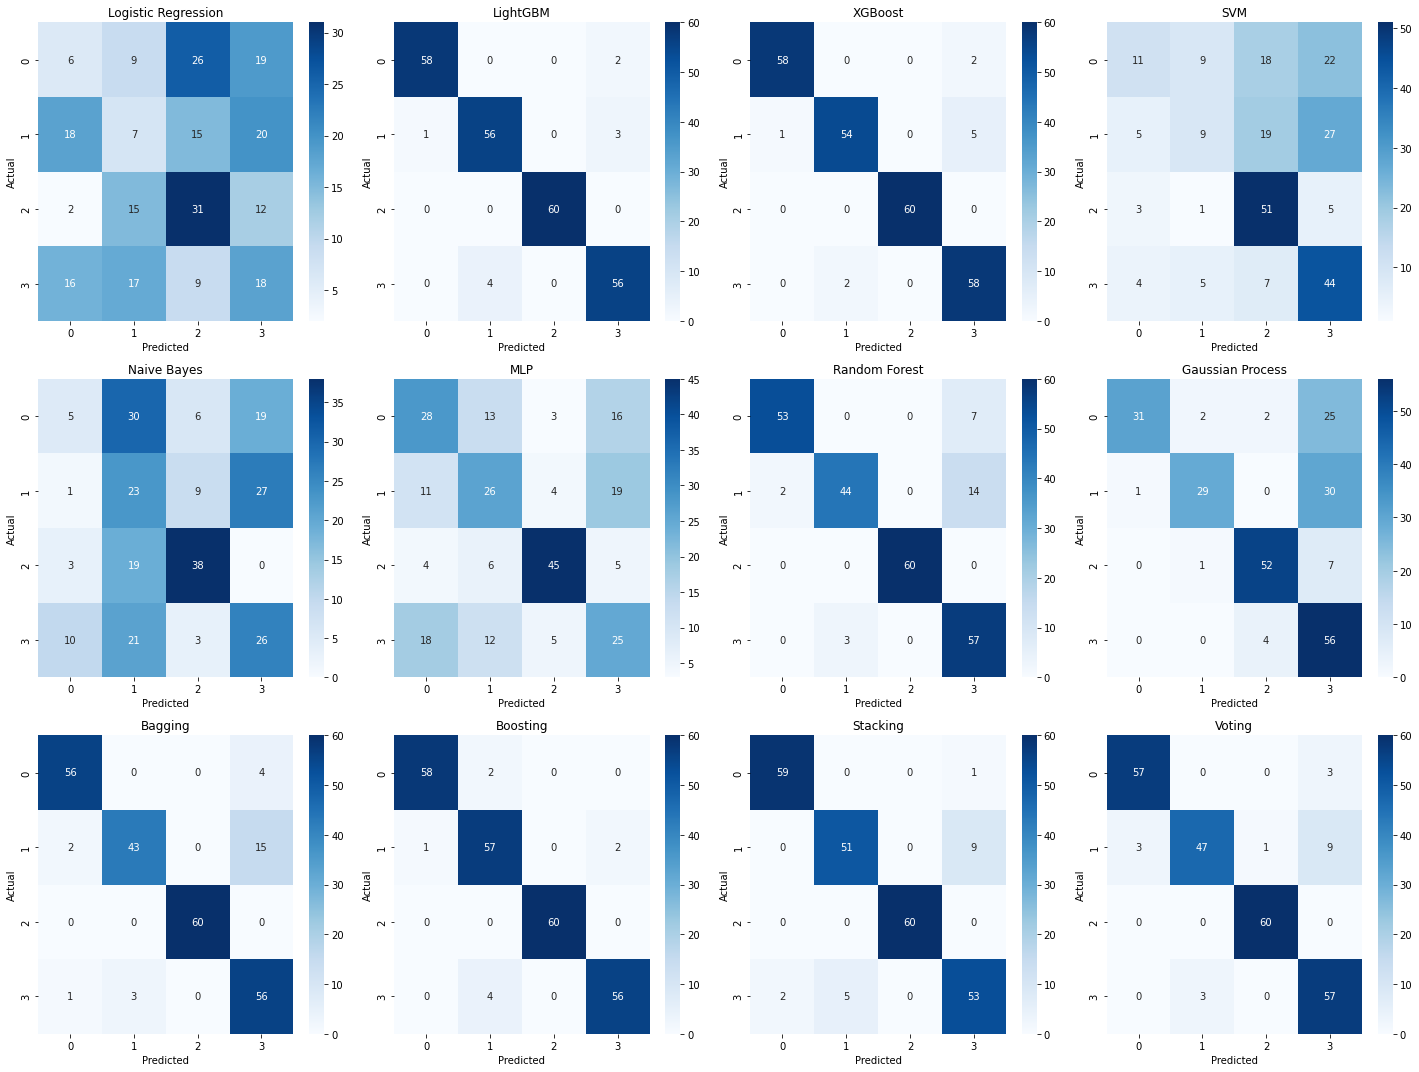

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.14      0.10      0.12        60
           1       0.15      0.12      0.13        60
           2       0.38      0.52      0.44        60
           3       0.26      0.30      0.28        60

    accuracy                           0.26       240
   macro avg       0.23      0.26      0.24       240
weighted avg       0.23      0.26      0.24       240

------------------------------------------------------------
Model: LightGBM
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.93      0.93      0.93        60
           2       1.00      1.00      1.00        60
           3       0.92      0.93      0.93        60

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240

--------------------------

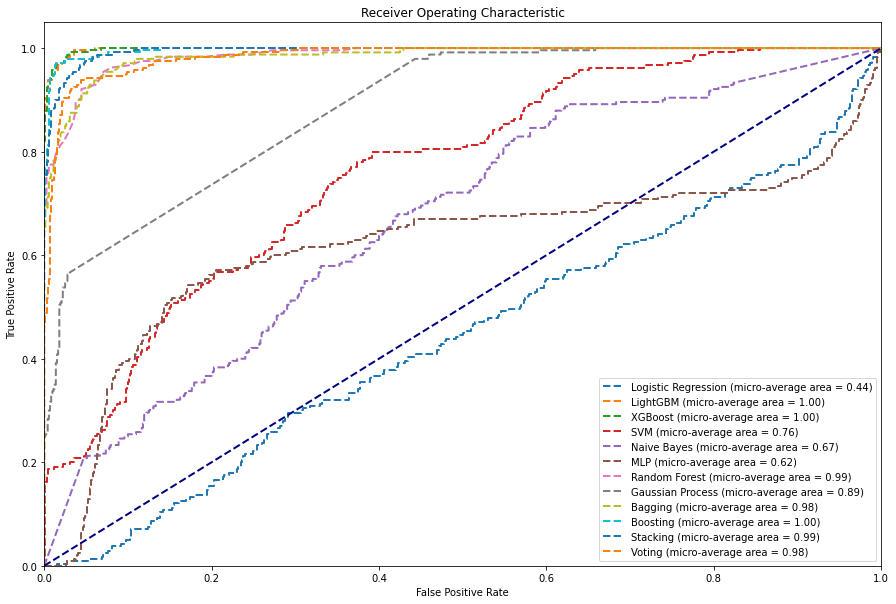

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 2
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 2
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.38629

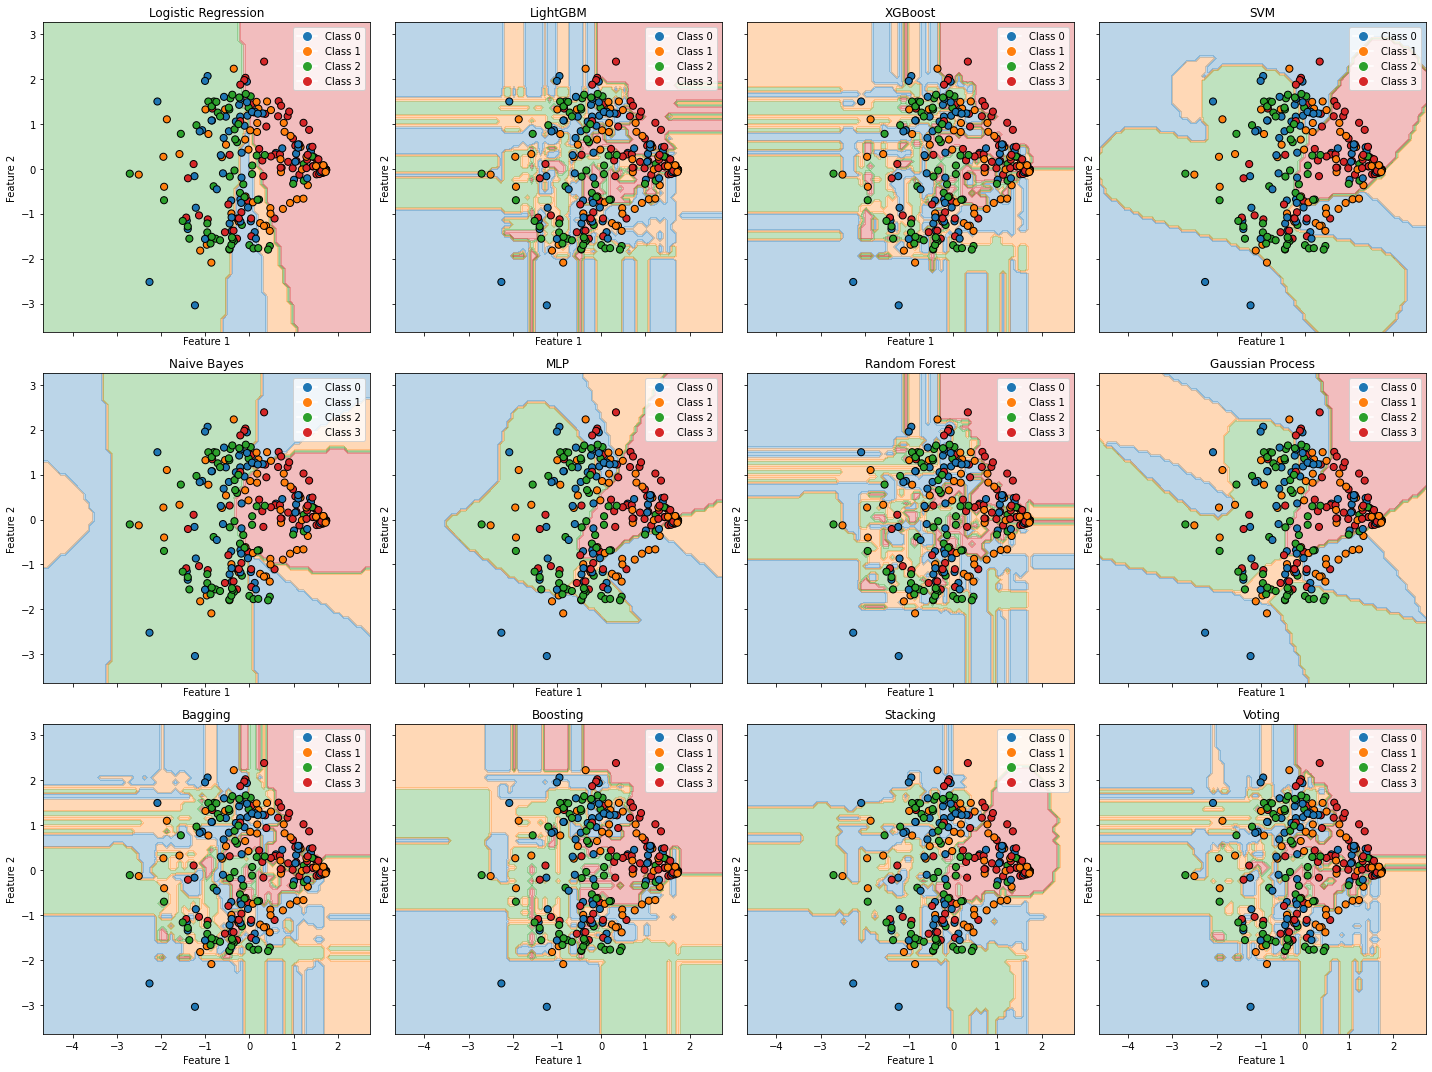

In [184]:
model_comp.plot_confusion_matrices()
model_comp.plot_classification_reports()
model_comp.plot_roc_curves()
model_comp.plot_decision_boundaries()

### Indviduals confusion matrices

In [92]:
Models_cm = model_comp.get_confusion_matrices()

In [117]:
Models_cm

{'Logistic Regression': array([[ 6,  9, 26, 19],
        [18,  7, 15, 20],
        [ 2, 15, 31, 12],
        [16, 17,  9, 18]], dtype=int64),
 'LightGBM': array([[58,  0,  0,  2],
        [ 1, 56,  0,  3],
        [ 0,  0, 60,  0],
        [ 0,  4,  0, 56]], dtype=int64),
 'XGBoost': array([[58,  0,  0,  2],
        [ 1, 54,  0,  5],
        [ 0,  0, 60,  0],
        [ 0,  2,  0, 58]], dtype=int64),
 'SVM': array([[11,  9, 18, 22],
        [ 5,  9, 19, 27],
        [ 3,  1, 51,  5],
        [ 4,  5,  7, 44]], dtype=int64),
 'Naive Bayes': array([[ 5, 30,  6, 19],
        [ 1, 23,  9, 27],
        [ 3, 19, 38,  0],
        [10, 21,  3, 26]], dtype=int64),
 'MLP': array([[28,  6,  9, 17],
        [13, 27,  1, 19],
        [ 6,  3, 45,  6],
        [17, 10,  8, 25]], dtype=int64),
 'Random Forest': array([[56,  0,  0,  4],
        [ 1, 45,  0, 14],
        [ 0,  0, 60,  0],
        [ 2,  3,  0, 55]], dtype=int64),
 'Gaussian Process': array([[31,  2,  2, 25],
        [ 1, 29,  0, 30],
   

In [193]:
def plot_cm_sub(cm, ax, title, cmap='viridis', annot_fontsize=24, cbar_fontsize=20):
    # Affichage graphique de la matrice de confusion
    class_labels = ['FR-I', 'FR-II', 'Compact', 'Bent']
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=class_labels, yticklabels=class_labels, ax=ax, annot_kws={"size": annot_fontsize}, cbar_kws={'ticks': [0, 20, 40, 60]})
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=cbar_fontsize)  # Set the colorbar ticks fontsize

    ax.set_xlabel('Predicted label', fontsize=25)
    ax.set_ylabel('True label', fontsize=25)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=70, ha='right', fontsize=20)
    ax.set_title(title, fontsize=26)


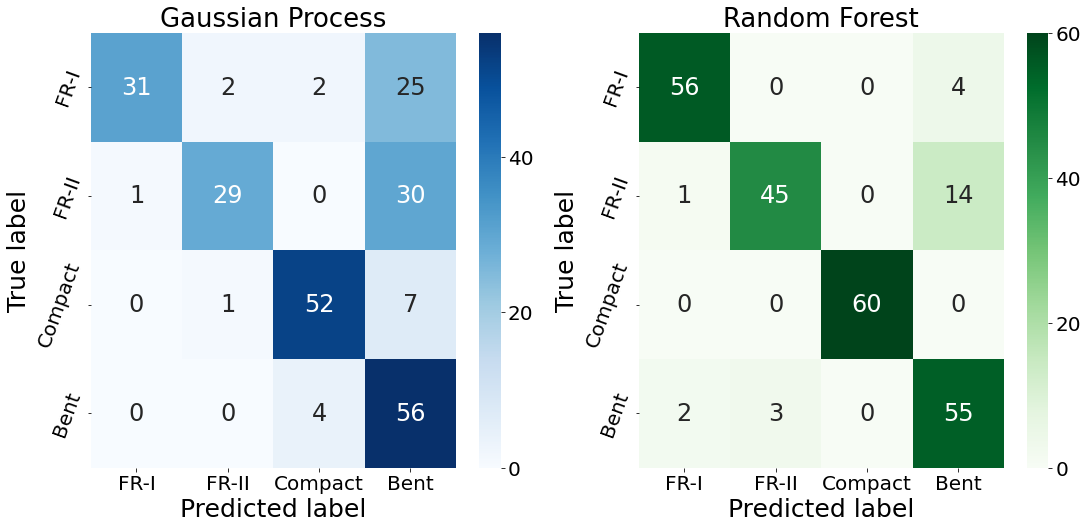

In [194]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Utilisez la fonction modifiée pour dessiner chaque matrice de confusion
plot_cm_sub(Models_cm['Gaussian Process'], axs[0], 'Gaussian Process', cmap='Blues')
plot_cm_sub(Models_cm['Random Forest'], axs[1], 'Random Forest', cmap='Greens')
#plot_cm_sub(cm_MLP, axs[1, 0], 'MLP', cmap='Reds')
#plot_cm_sub(cm_RF, axs[1, 1], 'RF', cmap='Purples')

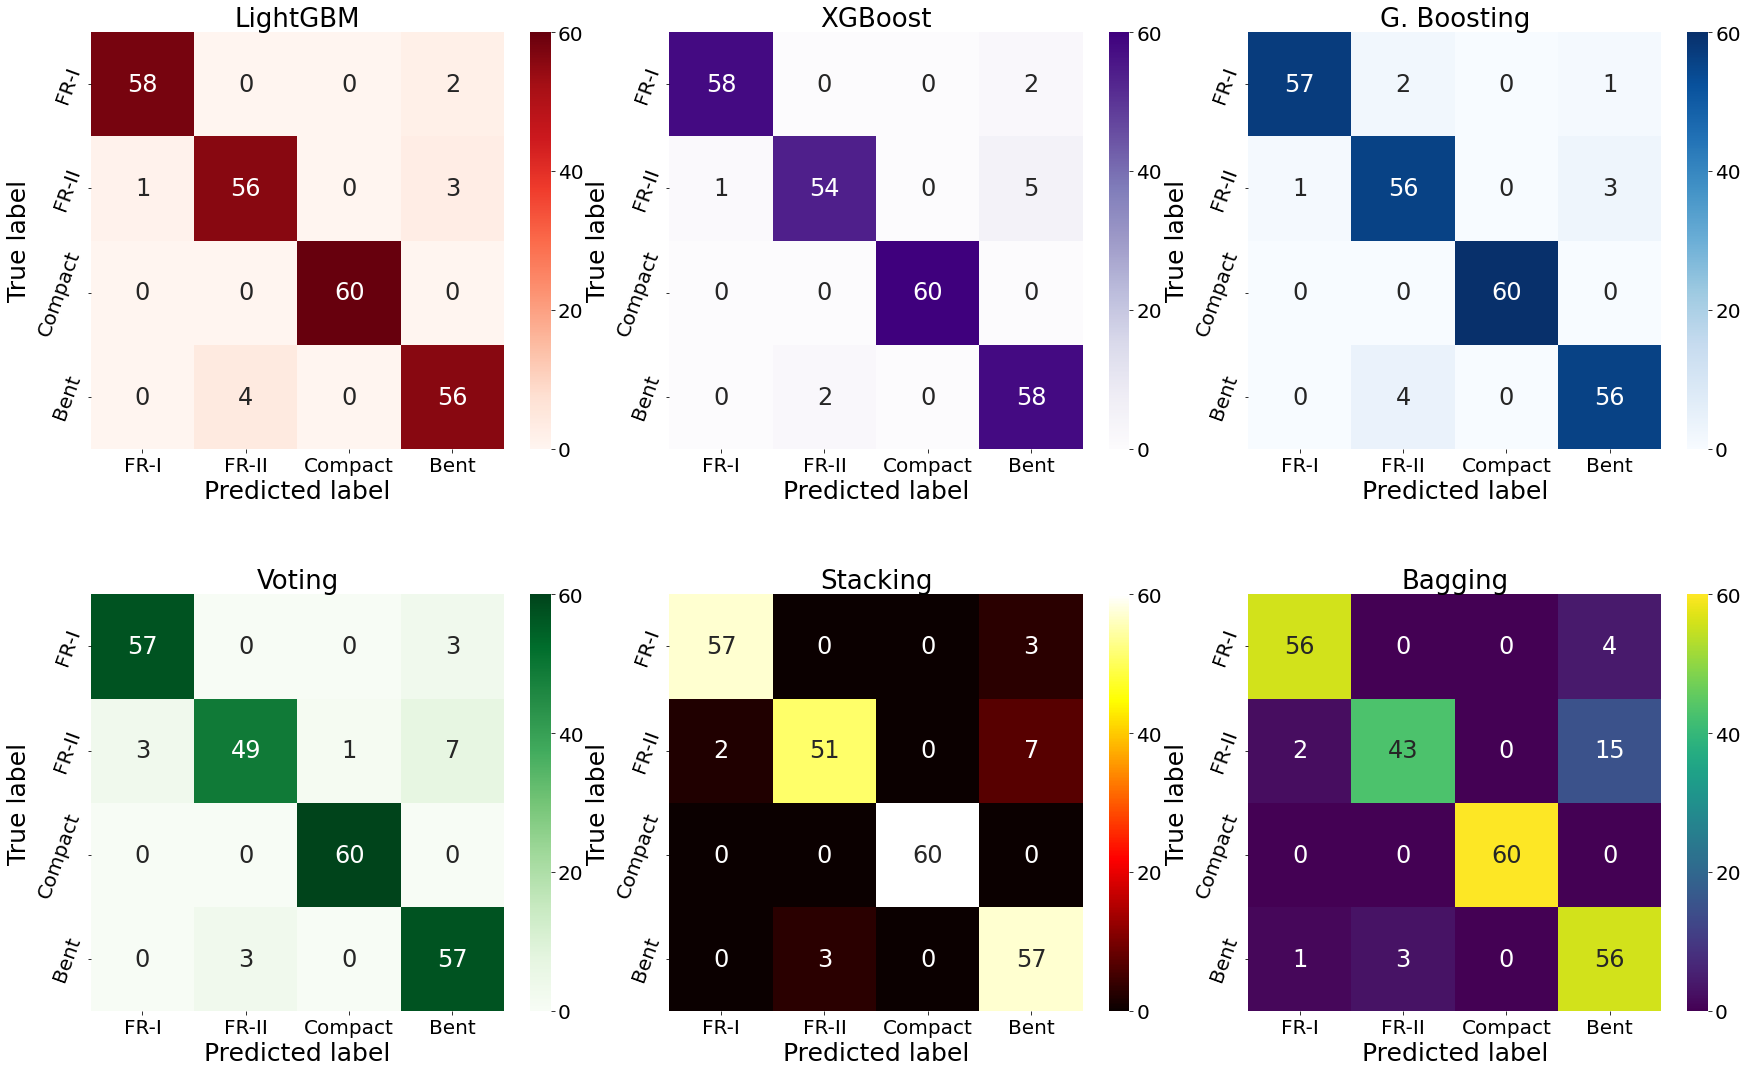

In [195]:
fig, axs = plt.subplots(2, 3, figsize=(30, 18))
fig.subplots_adjust(wspace=0.12, hspace=0.35)
# Utilisez la fonction modifiée pour dessiner chaque matrice de confusion
annot_fontsize=24
plot_cm_sub(Models_cm['LightGBM'], axs[0, 0], 'LightGBM', cmap='Reds', annot_fontsize=24)
plot_cm_sub(Models_cm['XGBoost'], axs[0, 1], 'XGBoost', cmap='Purples', annot_fontsize=24)
plot_cm_sub(Models_cm['Boosting'], axs[0, 2], 'G. Boosting', cmap='Blues', annot_fontsize=24)
plot_cm_sub(Models_cm['Stacking'], axs[1, 1], 'Stacking', cmap='hot', annot_fontsize=24)
plot_cm_sub(Models_cm['Voting'], axs[1, 0], 'Voting', cmap='Greens', annot_fontsize=24)
plot_cm_sub(Models_cm['Bagging'], axs[1, 2], 'Bagging', cmap='viridis', annot_fontsize=24)
